In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


Assume the data satisfies a certain log-likelihood function $\ell(y_i \mid x_i, \mathbf{w}) = y_i \ln(\sigma(\mathbf{w}^\intercal x_i)) + (1 - y_i)\ln(\sigma(-\mathbf{w}^\intercal x_i))$, We can use the gradient descent method to update $\mathbf{w}$ and reach a steady spot, which is $\mathbf{w}_{t} = \mathbf{w}_{t-1} + \nabla_{\mathbf{w}} F(\mathbf{w}_{t-1})$ and $\frac{\partial }{\partial w_j}\ell(y_i \mid x_i, \mathbf{w}) = y_{i}x_{ij}- \dfrac{x_{ij}\mathrm{e}^{\mathbf{w} ^\intercal x_{i}}}{\mathrm{e}^{\mathbf{w} ^\intercal x_{i}}+1}$. We can accelerate the update process by setting a up a rule that a small update will stop its update process. We can add an intecept by add one more feature with one to the $X$, which is $X_{i}padding = [X_{i},1]$. $\because$ the classification vector is a line that $0 = \mathbf{w}^\intercal x_i \Rightarrow x_{i}[0]\mathbf{w}[0]+x_{i}[1]\mathbf{w}[1]+\mathbf{w}[2]=0$ $\therefore x_{i}[1] = -(\frac{\mathbf{w}[0]}{\mathbf{w}[1]}x_{i}[0]+\frac{\mathbf{w}[2]}{\mathbf{w}[0]})$ and we can take this line as the classification hyperplane.If you still have some questions, I've done a lot of notations behind each line in my code.


In [19]:
def get_next_train_valid(X_shuffled, y_shuffled, k, itr = 0):
    """
    - itr value can tell you which fold you pick up for valid and rest go to training
    - use 1 fold for validation and all other folds for training
    - in next iteration, use a different fold for validation and remaining folds for training
        
    Basically, here you will determine which fold goes for validation and which ones for training
    """
    X_valid = X_shuffled[itr*len(X_shuffled)//k:(itr+1)*len(X_shuffled)//k,:]
    Y_valid = y_shuffled[itr*len(y_shuffled)//k:(itr+1)*len(y_shuffled)//k]
    X_train = np.delete(X_shuffled, np.s_[itr*len(X_shuffled)//k:(itr+1)*len(X_shuffled)//k:1], 0)
    Y_train = np.delete(y_shuffled, np.s_[itr*len(y_shuffled)//k:(itr+1)*len(y_shuffled)//k:1], 0)
    
    return  X_train, Y_train, X_valid, Y_valid

In [26]:
def train(X_train, Y_train, learning_rate, max_itr):
    
    # add one feature "1" to the feature matrix    
    X_train_pading = np.concatenate((X_train, np.ones((len(X_train),1))), axis=1)
    
    #initial W
    W = np.ones(X_train_pading.shape[1])

    
    for i in range(max_itr):
        
        #record the previous W
        W_pre  =  W 
        
        for m in range(len(X_train_pading)):
                
            #update W
            W = W + learning_rate* (Y_train[m] - 1/(1+np.exp(-  W.T @ X_train_pading[m])) ) * X_train_pading[m]
                
        # (optional)set up the threshold of escaping from the updating loop         
        ###if np.linalg.norm(W-W_pre)<10**(-5):
        
            #if update is really small, The W should be sit around the optimal spot, We can exit and save time for futher
            # calculation
            ###return W
            
                    
    return W
    
    

In [27]:
def predict(X_valid, W ):
    
    # add one feature "1" to the validation feature matrix  
    X_valid_pading = np.concatenate((X_valid, np.ones((len(X_valid),1))), axis=1)
    
    # using sign((h(w,x)-0.5)*2) to predict y
    y_predict = (np.sign(1/(1+np.exp(- X_valid_pading @ W))-1/2)+1)/2
    
    return y_predict

0.0
4.95
9.9
14.85
19.8
24.75
29.7
34.65
39.6
44.55
49.5
54.46
59.41
64.36


F:\AppStore\Anaconda\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp
F:\AppStore\Anaconda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


69.31
74.26
79.21
84.16
89.11
94.06
99.01


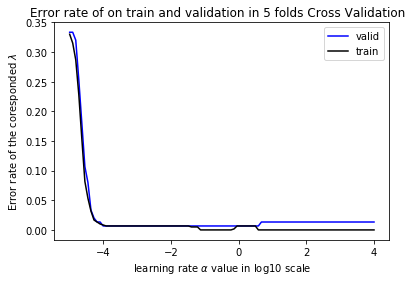

In [35]:
if __name__ == "__main__":
    #read the data without header
    data_X = pd.read_csv("IRISFeat.csv",header = None) .values
    data_y = pd.read_csv("IRISlabel.csv",header = None).values
    
    #merge x,y together for future shuffling
    samples = np.concatenate((data_X, data_y), axis=1)
    
    #shuffle [X,y]
    np.random.shuffle(samples)
    
    X_shuffled = samples[:,:-1]
    
    y_shuffled = samples[:,-1]
    
    #set up learning rate
    learning_rate_min = -5
    
    learning_rate_max = 4
    
    learning_num = 10**2 + 1
    
    #set up max iteration of update
    max_itr = 3*10**3
    
    #set up K fold parameter
    k = 5
    
    #set up learning rate set
    learning_rate_set = np.linspace(learning_rate_min, learning_rate_max, learning_num)
    
    #set up error rate set for validation set
    error_rate = np.zeros((k,len(learning_rate_set)))
    
    #set up error rate set for training set
    error_rate_train = np.zeros((k,len(learning_rate_set)))
    
    for index, learning_rate_power in np.ndenumerate(learning_rate_set):
        #(optional) help you to get over the boring time while you are waiting for result.
        # It always takes around 30mins or longrt to get the result
        #if you want to get it faster,please loose the threshold,reduced the learning num or lower the max_itr
        if index[0]%5 < 0.2 :
            print(np.round(index[0]/len(learning_rate_set)*100 , decimals = 2))
        
        learning_rate = 10 ** np.round(learning_rate_power, decimals = 2)
        
        for itr in range(k):
            
            #get training and validation data
            X_train, Y_train, X_valid, Y_valid = get_next_train_valid(X_shuffled, y_shuffled, k, itr)
            
            #get the model done by updating w with fixed learning rate
            W_set = train(X_train, Y_train, learning_rate, max_itr)
            
            # get the prediction of both training set and validation set
            y_predict_train = predict(X_train, W_set)
            
            # caculate Erroe rate
            error_rate_train[itr,index[0]] =np.sum(np.absolute(y_predict_train-Y_train))/len(Y_train) 
            
            #same prediction and error calculation here
            y_predict = predict(X_valid, W_set)
            
            error_rate[itr,index[0]] =np.sum(np.absolute(y_predict-Y_valid))/len(Y_valid) 
    
    #plotting the error map
    plt.xlabel(r'learning rate $\alpha$ value in log10 scale')
    plt.ylabel('Error rate of the coresponded '+ r'$\lambda$')
    plt.title('Error rate of on train and validation in 5 folds Cross Validation  ')
    plt.plot(learning_rate_set,  np.mean(error_rate,axis = 0), 'b',label = 'valid')   
    plt.plot(learning_rate_set,  np.mean(error_rate_train,axis = 0), 'k-', label = 'train')  
    plt.legend()    
            
        
    

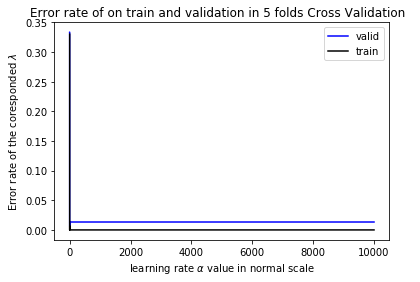

In [37]:
# plot in log scale
plt.xlabel(r'learning rate $\alpha$ value in normal scale')
plt.ylabel('Error rate of the coresponded '+ r'$\lambda$')
plt.title('Error rate of on train and validation in 5 folds Cross Validation  ')
plt.plot(10**learning_rate_set,  np.mean(error_rate,axis = 0), 'b',label = 'valid')   
plt.plot(10**learning_rate_set,  np.mean(error_rate_train,axis = 0), 'k-', label = 'train')  
plt.legend()   

As we can see, error is high in the region of head and tail. extreme learning rate(stepsize) will give you negative influence towarding updating process and make the model output wrong classifications.
if your learning rate is small, the updates will take millions of step to reach the opt spot.
if your learning rate is too big, the updates will jump back and forth around the opt spot and may have a chance that it will never touch the opt spot.

Therefore, moderdate stepsizes are usually good choices to make your life easier.



# run the following code
it will give you an example to prove it can classify the data correctly.


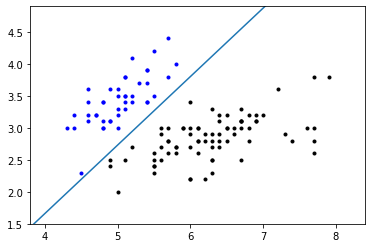

In [40]:

X_train, Y_train, X_valid, Y_valid = get_next_train_valid(X_shuffled, y_shuffled, k = 5, itr = 0)

W = train(X_train, Y_train, learning_rate=0.5, max_itr=10**4)


y_predict_train = predict(X_train, W)





for i in range(len(X_train)):
    if (Y_train[i] == 1):
        plt.plot(X_train[i,0], X_train[i,1] , '.k')
    else:
        plt.plot(X_train[i,0], X_train[i,1] , '.b')

x = np.arange(3.0, 9.0, 0.05)
y = -(W[0]/W[1]*x)-(W[2]/W[1])

plt.xlim(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5) 
plt.ylim(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5) 
plt.plot(x, y , '-')